In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
import fitsio
import pandas as pd
import time
import pickle

%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/hurra/Projects/survey-ops/')

In [3]:
import sys
sys.path.append('/home/hurra/Projects/survey-ops/')
from survey_ops.utils.units import *
from survey_ops.utils.geometry import *
from survey_ops.utils.interpolate import *
from survey_ops.utils.ephemerides import *
from survey_ops.src.environments import *
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [4]:
seed_everything(10)

# Load and cut data from fits file, save as .json

In [5]:
data_json_fn = '../data/data.json'
data_fits_fn = '../data/decam-exposures-20251107.fits.gz'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read('../data/decam-exposures-20251107.fits.gz')
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    print(df['datetime'].dtype)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


# Instantiate the offline dataset choosing number of bins for (az,el)

In [10]:
dataset.stateidx2name

{0: 'ra',
 1: 'dec',
 2: 'azimuth',
 3: 'elevation',
 4: 'sun_azimuth',
 5: 'sun_elevation',
 6: 'moon_azimuth',
 7: 'moon_elevation',
 8: 'airmass',
 9: 'hour_angle',
 10: 'timestamp'}

In [37]:
dataset._all_states[1]

array([ 3.01199036e+02, -5.09383316e+01,  1.39550003e+02,  5.77900009e+01,
        5.03098869e+00,  1.25236845e+00,  4.42522717e+00, -3.21283579e-01,
        1.17999995e+00, -3.32084579e+01,  1.37799331e+09])

In [38]:
dataset.next_states

tensor([[ 1.5055, -0.8494, -1.0311,  ..., -0.2168, -2.0832, -1.5595],
        [ 1.5027, -0.9535, -0.9825,  ..., -0.1346, -2.0510, -1.5595],
        [ 1.4996, -1.0576, -0.9356,  ..., -0.0524, -2.0165, -1.5595],
        ...,
        [-0.4647, -0.0859,  0.3646,  ...,  1.6741,  1.3055,  1.7469],
        [-0.4649, -0.0944,  0.3607,  ...,  1.7563,  1.3197,  1.7469],
        [-0.4649, -0.0944,  0.3594,  ...,  1.8386,  1.3425,  1.7469]])

In [56]:
# num_bins_1d = 19

dataset = OfflineDECamDataset(
    df, 
    binning_method='healpix',
    nside=8,
    # num_bins_1d=num_bins_1d, 
    normalize_state=True,
    # specific_years=[2014]
)

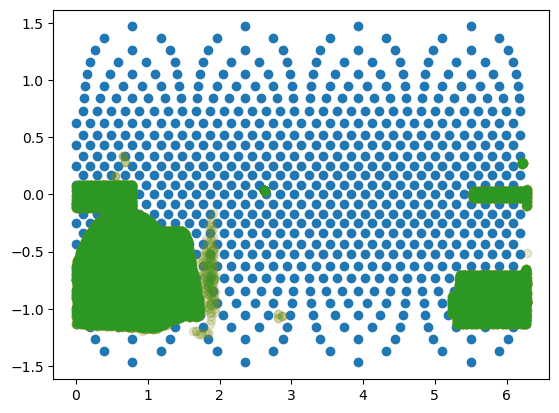

In [57]:
next_states = (dataset.next_states * dataset.stds + dataset.means)
plt.scatter(dataset.hpGrid.lon, dataset.hpGrid.lat)
plt.scatter(dataset.ra*deg, dataset.dec*deg, alpha=.1)
plt.scatter(next_states[:, dataset.statename2stateidx['ra']] * deg, next_states[:, dataset.statename2stateidx['dec']]*deg, alpha=.1)

In [63]:
idx = dataset.hpGrid.ang2idx(lon=dataset._df.ra.values * deg, lat=dataset._df.dec.values * deg)

In [73]:
np.argmin(dataset.hpGrid.get_angular_separations(lon=dataset._df.ra.values[0]*deg, lat=dataset._df.dec.values[0]*deg))

np.int64(679)

In [7]:
T_obs = []
for day, subdf in dataset._groups:
    timestamps = subdf['timestamp'].values
    T_obs.append(timestamps[-1] - timestamps[0])


In [8]:
T_obs = np.array(T_obs)/60/60

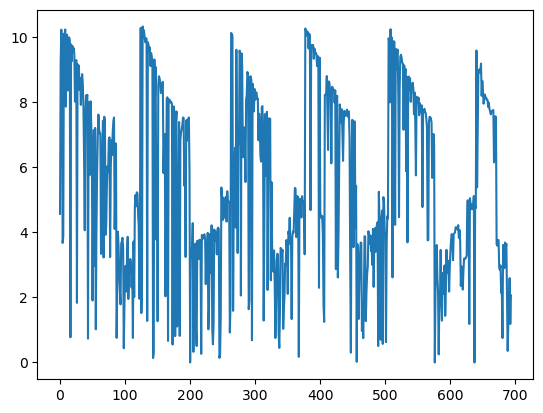

In [9]:
plt.plot(T_obs)

## You can also specify years, months, days, and filters to get a smaller subset of transitions

### First night of survey, all filters

In [12]:
num_bins_1d = 19
dataset = OfflineDataset(
    df, 
    num_bins_1d=19, 
    normalize_state=True,
    specific_years=[2013],
    specific_months=[8],
    # specific_days=np.arange(2, 4),
    # specific_filters=['r', 'g']
)

In [13]:
dataset._df

,expnum,ra,dec,exptime,filter,propid,program,teff,fwhm,datetime,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff,timestamp,night
0,229250,301.199036,-50.938332,90,g,2012B-0001,survey,0.41,1.15,2013-08-31 23:55:07,139.550003,32.209999,-33.208458,1.18,1.15,0.42,1.26,0.41,1377993307,2013-08-31
1,229251,300.851105,-52.967278,90,g,2012B-0001,survey,0.60,1.18,2013-08-31 23:57:08,143.320007,32.759998,-32.380917,1.19,1.18,0.15,1.23,0.60,1377993428,2013-08-31
2,229252,300.460083,-54.996220,90,g,2012B-0001,survey,0.62,1.17,2013-08-31 23:59:08,146.949997,33.419998,-31.494499,1.20,1.17,-0.07,1.22,0.62,1377993548,2013-08-31
3,229253,300.016754,-57.024887,90,g,2012B-0001,survey,0.52,1.29,2013-09-01 00:01:11,150.449997,34.209999,-30.536041,1.21,1.29,-0.21,1.20,0.52,1377993671,2013-08-31
4,229254,302.722076,-58.040192,90,g,2012B-0001,survey,0.44,1.40,2013-09-01 00:03:13,150.589996,35.759998,-32.738377,1.23,1.40,0.04,1.20,0.44,1377993793,2013-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,229362,324.616028,-53.981499,90,r,2012B-0001,survey,0.76,0.86,2013-09-01 04:20:30,193.940002,24.790001,9.914000,1.10,0.86,0.39,2.94,0.76,1378009230,2013-08-31
112,229363,308.637512,-56.011250,90,i,2012B-0001,survey,1.24,0.84,2013-09-01 04:23:03,208.240005,31.809999,26.498501,1.18,0.84,0.23,6.89,1.24,1378009383,2013-08-31
113,229364,314.232361,-56.010166,90,r,2012B-0001,survey,0.57,0.87,2013-09-01 04:25:11,204.220001,29.870001,21.446125,1.15,0.87,0.48,3.21,0.57,1378009511,2013-08-31
114,229365,314.236420,-56.010414,90,i,2012B-0001,survey,1.10,0.82,2013-09-01 04:27:11,204.580002,30.020000,21.859875,1.15,0.82,0.32,6.94,1.10,1378009631,2013-08-31


# Configure model, data selection, and training setup

In [14]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [15]:
num_bins_1d = 19
dataset = OfflineDataset(
    df, 
    num_bins_1d=19, 
    normalize_state=True,
    specific_years=[2013],
    specific_months=[8],
    # specific_days=np.arange(2, 4),
    # specific_filters=['r', 'g']
)

In [16]:
batch_size = 32
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [17]:
"""Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 64,
    'device': device,
    'lr': 3e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 100,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'TelescopeEnv-v0'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config):
    exp_name = f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': dataset.normalize_state,
    'outdir': outdir
    }

agent = Agent(**agent_config)



# Visualize dataset in (az, el) and binning sizes

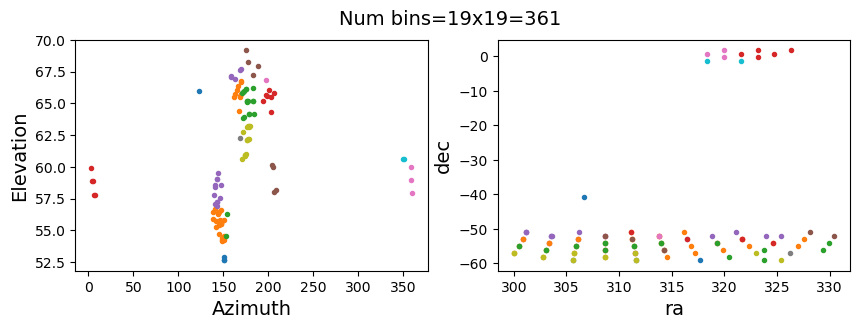

In [18]:
s = 1000/len(dataset)
fig, axs = plt.subplots(1,2, figsize=(10,3))
for bin_id in dataset.id2azel.keys():
    field_ids = np.array(dataset.id2azel[bin_id])
    axs[0].scatter(field_ids[:, 0], field_ids[:, 1], label='bin' + str(bin_id), s=s)
axs[0].set_xlabel('Azimuth', fontsize=14)
axs[0].set_ylabel('Elevation', fontsize=14)

for bin_id in dataset.id2radec.keys():
    field_ids = np.array(dataset.id2radec[bin_id])
    axs[1].scatter(field_ids[:, 0], field_ids[:, 1], label='bin' + str(bin_id), s=s)
axs[1].set_xlabel('ra', fontsize=14)
axs[1].set_ylabel('dec', fontsize=14)

fig.suptitle(f'Num bins={num_bins_1d}x{num_bins_1d}={dataset.num_actions}', fontsize=14)
fig.savefig(fig_outdir + 'plot_observations_in_sky_colored_bins.png')

# Train

In [19]:
start_time = time.time()
"""Train"""
agent.fit(
    dataloader=trainloader,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(f'Total train time = {train_time}s')

  0%|                                                 | 0/11600 [00:00<?, ?it/s]/home/rachel/Projects/survey-ops/notebooks/../survey_ops/src/algorithms.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expert_actions = torch.tensor(expert_actions, device=self.device, dtype=torch.long) # needs to be long for .gather()
/home/rachel/Projects/survey-ops/notebooks/../survey_ops/src/agents.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_obs = torch.tensor(eval_obs, device=self.device)
/home/rachel/Projects/survey-ops/notebooks/../survey_ops/src/agents.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

Train step 0: Accuracy = 0.031, Loss = 5.8807


  1%|▍                                     | 143/11600 [00:00<00:43, 261.99it/s]

Train step 100: Accuracy = 0.406, Loss = 1.4607


  2%|▊                                     | 235/11600 [00:00<00:39, 288.00it/s]

Train step 200: Accuracy = 0.688, Loss = 0.9631


  3%|█▏                                    | 355/11600 [00:01<00:38, 292.63it/s]

Train step 300: Accuracy = 0.844, Loss = 0.9560


  4%|█▍                                    | 446/11600 [00:01<00:38, 289.72it/s]

Train step 400: Accuracy = 0.656, Loss = 1.0404


  5%|█▊                                    | 537/11600 [00:01<00:37, 296.88it/s]

Train step 500: Accuracy = 0.438, Loss = 0.9484


  6%|██▏                                   | 659/11600 [00:02<00:36, 301.66it/s]

Train step 600: Accuracy = 0.625, Loss = 0.8546


  6%|██▍                                   | 750/11600 [00:02<00:36, 296.80it/s]

Train step 700: Accuracy = 0.750, Loss = 0.7202


  7%|██▊                                   | 842/11600 [00:02<00:36, 294.86it/s]

Train step 800: Accuracy = 0.719, Loss = 0.6510


  8%|███                                   | 933/11600 [00:03<00:36, 294.89it/s]

Train step 900: Accuracy = 0.438, Loss = 0.6476


  9%|███▎                                 | 1054/11600 [00:03<00:35, 297.66it/s]

Train step 1000: Accuracy = 0.781, Loss = 0.6585


 10%|███▋                                 | 1146/11600 [00:04<00:34, 298.75it/s]

Train step 1100: Accuracy = 0.844, Loss = 0.8612


 11%|███▉                                 | 1235/11600 [00:04<00:36, 282.75it/s]

Train step 1200: Accuracy = 0.781, Loss = 0.7629


 12%|████▎                                | 1343/11600 [00:04<00:42, 242.10it/s]

Train step 1300: Accuracy = 0.844, Loss = 0.5615


 12%|████▌                                | 1447/11600 [00:05<00:40, 251.50it/s]

Train step 1400: Accuracy = 0.812, Loss = 0.6047


 13%|████▉                                | 1536/11600 [00:05<00:36, 276.85it/s]

Train step 1500: Accuracy = 0.719, Loss = 0.4937


 14%|█████▎                               | 1656/11600 [00:05<00:33, 294.08it/s]

Train step 1600: Accuracy = 0.656, Loss = 0.5273


 15%|█████▌                               | 1748/11600 [00:06<00:33, 297.29it/s]

Train step 1700: Accuracy = 0.812, Loss = 0.6654


 16%|█████▊                               | 1841/11600 [00:06<00:33, 293.71it/s]

Train step 1800: Accuracy = 0.938, Loss = 0.5870


 17%|██████▏                              | 1933/11600 [00:06<00:32, 300.50it/s]

Train step 1900: Accuracy = 0.781, Loss = 0.4374


 18%|██████▌                              | 2055/11600 [00:07<00:32, 296.10it/s]

Train step 2000: Accuracy = 0.812, Loss = 0.3304


 19%|██████▊                              | 2147/11600 [00:07<00:31, 300.39it/s]

Train step 2100: Accuracy = 0.906, Loss = 0.3469


 19%|███████▏                             | 2239/11600 [00:07<00:32, 285.79it/s]

Train step 2200: Accuracy = 0.812, Loss = 0.5010


 20%|███████▌                             | 2355/11600 [00:08<00:33, 279.13it/s]

Train step 2300: Accuracy = 0.781, Loss = 0.3060


 21%|███████▊                             | 2442/11600 [00:08<00:32, 284.27it/s]

Train step 2400: Accuracy = 0.812, Loss = 0.3240


 22%|████████                             | 2533/11600 [00:08<00:30, 293.42it/s]

Train step 2500: Accuracy = 0.875, Loss = 0.2960


 23%|████████▍                            | 2654/11600 [00:09<00:30, 296.94it/s]

Train step 2600: Accuracy = 0.844, Loss = 0.3966


 24%|████████▊                            | 2745/11600 [00:09<00:30, 293.80it/s]

Train step 2700: Accuracy = 0.781, Loss = 0.3993


 24%|█████████                            | 2835/11600 [00:10<00:30, 290.96it/s]

Train step 2800: Accuracy = 0.781, Loss = 0.2745


 25%|█████████▍                           | 2955/11600 [00:10<00:29, 291.81it/s]

Train step 2900: Accuracy = 0.938, Loss = 0.2591


 26%|█████████▋                           | 3047/11600 [00:10<00:28, 298.05it/s]

Train step 3000: Accuracy = 0.938, Loss = 0.2669


 27%|██████████                           | 3137/11600 [00:11<00:29, 284.59it/s]

Train step 3100: Accuracy = 0.812, Loss = 0.2730


 28%|██████████▎                          | 3252/11600 [00:11<00:29, 281.98it/s]

Train step 3200: Accuracy = 0.844, Loss = 0.1493


 29%|██████████▋                          | 3341/11600 [00:11<00:28, 290.34it/s]

Train step 3300: Accuracy = 0.906, Loss = 0.1851


 30%|██████████▉                          | 3435/11600 [00:12<00:27, 301.67it/s]

Train step 3400: Accuracy = 0.875, Loss = 0.1177


 31%|███████████▎                         | 3559/11600 [00:12<00:26, 300.45it/s]

Train step 3500: Accuracy = 0.875, Loss = 0.2093


 31%|███████████▌                         | 3621/11600 [00:12<00:30, 258.52it/s]

Train step 3600: Accuracy = 0.844, Loss = 0.2114


 32%|███████████▉                         | 3741/11600 [00:13<00:27, 288.09it/s]

Train step 3700: Accuracy = 0.938, Loss = 0.1946


 33%|████████████▏                        | 3829/11600 [00:13<00:33, 230.26it/s]

Train step 3800: Accuracy = 0.969, Loss = 0.1812


 34%|████████████▌                        | 3946/11600 [00:13<00:28, 269.70it/s]

Train step 3900: Accuracy = 0.906, Loss = 0.1762


 35%|████████████▊                        | 4034/11600 [00:14<00:26, 282.07it/s]

Train step 4000: Accuracy = 0.906, Loss = 0.1970


 36%|█████████████▏                       | 4153/11600 [00:14<00:25, 288.08it/s]

Train step 4100: Accuracy = 0.875, Loss = 0.2664


 37%|█████████████▌                       | 4243/11600 [00:15<00:24, 294.89it/s]

Train step 4200: Accuracy = 1.000, Loss = 0.1127


 37%|█████████████▊                       | 4334/11600 [00:15<00:24, 297.04it/s]

Train step 4300: Accuracy = 0.938, Loss = 0.1541


 38%|██████████████▏                      | 4455/11600 [00:15<00:23, 298.36it/s]

Train step 4400: Accuracy = 1.000, Loss = 0.1817


 39%|██████████████▌                      | 4548/11600 [00:16<00:23, 297.63it/s]

Train step 4500: Accuracy = 0.969, Loss = 0.1189


 40%|██████████████▊                      | 4639/11600 [00:16<00:23, 298.81it/s]

Train step 4600: Accuracy = 0.812, Loss = 0.2600


 41%|███████████████                      | 4728/11600 [00:16<00:24, 280.23it/s]

Train step 4700: Accuracy = 0.750, Loss = 0.3806


 42%|███████████████▍                     | 4845/11600 [00:17<00:23, 286.29it/s]

Train step 4800: Accuracy = 0.938, Loss = 0.2110


 43%|███████████████▋                     | 4936/11600 [00:17<00:22, 293.14it/s]

Train step 4900: Accuracy = 0.906, Loss = 0.2655


 44%|████████████████                     | 5054/11600 [00:17<00:22, 288.17it/s]

Train step 5000: Accuracy = 0.969, Loss = 0.1124


 44%|████████████████▍                    | 5146/11600 [00:18<00:21, 296.58it/s]

Train step 5100: Accuracy = 1.000, Loss = 0.0302


 45%|████████████████▋                    | 5237/11600 [00:18<00:21, 298.78it/s]

Train step 5200: Accuracy = 0.906, Loss = 0.0613


 46%|█████████████████                    | 5359/11600 [00:18<00:21, 294.17it/s]

Train step 5300: Accuracy = 0.969, Loss = 0.0948


 47%|█████████████████▍                   | 5450/11600 [00:19<00:20, 297.94it/s]

Train step 5400: Accuracy = 0.969, Loss = 0.1089


 48%|█████████████████▋                   | 5544/11600 [00:19<00:20, 299.04it/s]

Train step 5500: Accuracy = 0.969, Loss = 0.2216


 49%|█████████████████▉                   | 5635/11600 [00:19<00:20, 297.24it/s]

Train step 5600: Accuracy = 0.969, Loss = 0.0941


 50%|██████████████████▎                  | 5756/11600 [00:20<00:19, 294.01it/s]

Train step 5700: Accuracy = 0.938, Loss = 0.0879


 50%|██████████████████▋                  | 5847/11600 [00:20<00:19, 297.25it/s]

Train step 5800: Accuracy = 0.969, Loss = 0.0808


 51%|██████████████████▉                  | 5937/11600 [00:20<00:19, 289.60it/s]

Train step 5900: Accuracy = 1.000, Loss = 0.0612


 52%|███████████████████▎                 | 6057/11600 [00:21<00:18, 293.73it/s]

Train step 6000: Accuracy = 0.906, Loss = 0.1060


 53%|███████████████████▌                 | 6148/11600 [00:21<00:18, 292.61it/s]

Train step 6100: Accuracy = 0.938, Loss = 0.4131


 54%|███████████████████▉                 | 6239/11600 [00:21<00:18, 294.05it/s]

Train step 6200: Accuracy = 0.906, Loss = 0.2055


 55%|████████████████████▎                | 6356/11600 [00:22<00:18, 279.10it/s]

Train step 6300: Accuracy = 0.938, Loss = 0.0648


 56%|████████████████████▌                | 6443/11600 [00:22<00:18, 284.59it/s]

Train step 6400: Accuracy = 0.969, Loss = 0.0763


 56%|████████████████████▊                | 6533/11600 [00:22<00:17, 291.19it/s]

Train step 6500: Accuracy = 0.969, Loss = 0.1038


 57%|█████████████████████▏               | 6654/11600 [00:23<00:16, 293.81it/s]

Train step 6600: Accuracy = 0.938, Loss = 0.1820


 58%|█████████████████████▌               | 6746/11600 [00:23<00:16, 296.51it/s]

Train step 6700: Accuracy = 0.906, Loss = 0.1270


 59%|█████████████████████▊               | 6835/11600 [00:23<00:16, 286.17it/s]

Train step 6800: Accuracy = 0.969, Loss = 0.0341


 60%|██████████████████████▏              | 6954/11600 [00:24<00:15, 292.78it/s]

Train step 6900: Accuracy = 1.000, Loss = 0.0740


 61%|██████████████████████▍              | 7045/11600 [00:24<00:15, 294.06it/s]

Train step 7000: Accuracy = 0.969, Loss = 0.0644


 62%|██████████████████████▊              | 7135/11600 [00:24<00:15, 292.47it/s]

Train step 7100: Accuracy = 0.969, Loss = 0.0412


 63%|███████████████████████▏             | 7257/11600 [00:25<00:14, 293.54it/s]

Train step 7200: Accuracy = 0.969, Loss = 0.3237


 63%|███████████████████████▍             | 7348/11600 [00:25<00:14, 296.09it/s]

Train step 7300: Accuracy = 1.000, Loss = 0.1297


 64%|███████████████████████▋             | 7438/11600 [00:25<00:14, 292.11it/s]

Train step 7400: Accuracy = 0.969, Loss = 0.0659


 65%|████████████████████████             | 7558/11600 [00:26<00:14, 288.52it/s]

Train step 7500: Accuracy = 0.969, Loss = 0.0916


 66%|████████████████████████▍            | 7645/11600 [00:26<00:14, 280.70it/s]

Train step 7600: Accuracy = 0.938, Loss = 0.0270


 67%|████████████████████████▋            | 7735/11600 [00:26<00:13, 288.78it/s]

Train step 7700: Accuracy = 1.000, Loss = 0.0630


 67%|████████████████████████▉            | 7824/11600 [00:27<00:13, 279.99it/s]

Train step 7800: Accuracy = 0.969, Loss = 0.0820


 68%|█████████████████████████▎           | 7939/11600 [00:27<00:13, 279.76it/s]

Train step 7900: Accuracy = 0.938, Loss = 0.0625


 69%|█████████████████████████▋           | 8057/11600 [00:28<00:12, 289.31it/s]

Train step 8000: Accuracy = 0.969, Loss = 0.0512


 70%|█████████████████████████▉           | 8144/11600 [00:28<00:12, 283.89it/s]

Train step 8100: Accuracy = 0.969, Loss = 0.3626


 71%|██████████████████████████▎          | 8233/11600 [00:28<00:11, 292.12it/s]

Train step 8200: Accuracy = 0.969, Loss = 0.1471


 72%|██████████████████████████▋          | 8355/11600 [00:29<00:10, 300.60it/s]

Train step 8300: Accuracy = 0.969, Loss = 0.1840


 73%|██████████████████████████▉          | 8447/11600 [00:29<00:10, 298.40it/s]

Train step 8400: Accuracy = 1.000, Loss = 0.0363


 74%|███████████████████████████▏         | 8538/11600 [00:29<00:10, 300.03it/s]

Train step 8500: Accuracy = 0.969, Loss = 0.0358


 75%|███████████████████████████▌         | 8659/11600 [00:30<00:10, 292.19it/s]

Train step 8600: Accuracy = 1.000, Loss = 0.0306


 75%|███████████████████████████▉         | 8749/11600 [00:30<00:09, 292.21it/s]

Train step 8700: Accuracy = 1.000, Loss = 0.0459


 76%|████████████████████████████▏        | 8839/11600 [00:30<00:09, 294.12it/s]

Train step 8800: Accuracy = 1.000, Loss = 0.0420


 77%|████████████████████████████▌        | 8959/11600 [00:31<00:09, 290.72it/s]

Train step 8900: Accuracy = 1.000, Loss = 0.0106


 78%|████████████████████████████▊        | 9048/11600 [00:31<00:09, 281.83it/s]

Train step 9000: Accuracy = 0.969, Loss = 0.0708


 79%|█████████████████████████████▏       | 9136/11600 [00:31<00:08, 286.98it/s]

Train step 9100: Accuracy = 1.000, Loss = 0.0448


 80%|█████████████████████████████▌       | 9256/11600 [00:32<00:08, 290.28it/s]

Train step 9200: Accuracy = 0.969, Loss = 0.0852


 81%|█████████████████████████████▊       | 9346/11600 [00:32<00:07, 289.14it/s]

Train step 9300: Accuracy = 0.969, Loss = 0.0172


 81%|██████████████████████████████       | 9437/11600 [00:32<00:07, 292.35it/s]

Train step 9400: Accuracy = 1.000, Loss = 0.0334


 82%|██████████████████████████████▍      | 9559/11600 [00:33<00:07, 289.69it/s]

Train step 9500: Accuracy = 0.969, Loss = 0.0710


 83%|██████████████████████████████▊      | 9649/11600 [00:33<00:06, 292.21it/s]

Train step 9600: Accuracy = 1.000, Loss = 0.0580


 84%|███████████████████████████████      | 9741/11600 [00:33<00:06, 298.25it/s]

Train step 9700: Accuracy = 1.000, Loss = 0.0121


 85%|███████████████████████████████▎     | 9832/11600 [00:34<00:06, 292.48it/s]

Train step 9800: Accuracy = 0.969, Loss = 0.0041


 86%|███████████████████████████████▋     | 9952/11600 [00:34<00:05, 294.27it/s]

Train step 9900: Accuracy = 1.000, Loss = 0.0081


 87%|███████████████████████████████▏    | 10042/11600 [00:34<00:05, 292.95it/s]

Train step 10000: Accuracy = 0.969, Loss = 0.0079


 87%|███████████████████████████████▍    | 10133/11600 [00:35<00:04, 296.67it/s]

Train step 10100: Accuracy = 0.938, Loss = 0.0309


 88%|███████████████████████████████▊    | 10254/11600 [00:35<00:04, 294.08it/s]

Train step 10200: Accuracy = 0.969, Loss = 0.0634


 89%|████████████████████████████████    | 10345/11600 [00:35<00:04, 299.13it/s]

Train step 10300: Accuracy = 0.969, Loss = 0.0818


 90%|████████████████████████████████▍   | 10438/11600 [00:36<00:03, 299.22it/s]

Train step 10400: Accuracy = 0.969, Loss = 0.0039


 91%|████████████████████████████████▊   | 10556/11600 [00:36<00:03, 279.63it/s]

Train step 10500: Accuracy = 1.000, Loss = 0.0243


 92%|█████████████████████████████████   | 10648/11600 [00:37<00:03, 294.49it/s]

Train step 10600: Accuracy = 0.969, Loss = 0.0085


 93%|█████████████████████████████████▎  | 10741/11600 [00:37<00:02, 301.87it/s]

Train step 10700: Accuracy = 1.000, Loss = 0.0326


 93%|█████████████████████████████████▌  | 10834/11600 [00:37<00:02, 300.04it/s]

Train step 10800: Accuracy = 1.000, Loss = 0.0246


 94%|██████████████████████████████████  | 10957/11600 [00:38<00:02, 297.67it/s]

Train step 10900: Accuracy = 0.875, Loss = 0.0614


 95%|██████████████████████████████████▎ | 11050/11600 [00:38<00:01, 301.37it/s]

Train step 11000: Accuracy = 0.938, Loss = 0.4032


 96%|██████████████████████████████████▌ | 11143/11600 [00:38<00:01, 299.59it/s]

Train step 11100: Accuracy = 0.938, Loss = 1.3599


 97%|██████████████████████████████████▊ | 11235/11600 [00:38<00:01, 300.47it/s]

Train step 11200: Accuracy = 0.938, Loss = 0.0760


 98%|███████████████████████████████████▏| 11358/11600 [00:39<00:00, 298.72it/s]

Train step 11300: Accuracy = 1.000, Loss = 0.0205


 99%|███████████████████████████████████▌| 11449/11600 [00:39<00:00, 292.91it/s]

Train step 11400: Accuracy = 1.000, Loss = 0.0188


 99%|███████████████████████████████████▊| 11541/11600 [00:39<00:00, 299.31it/s]

Train step 11500: Accuracy = 1.000, Loss = 0.1322


100%|████████████████████████████████████| 11600/11600 [00:40<00:00, 288.68it/s]


Total train time = 40.304519176483154s


In [20]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

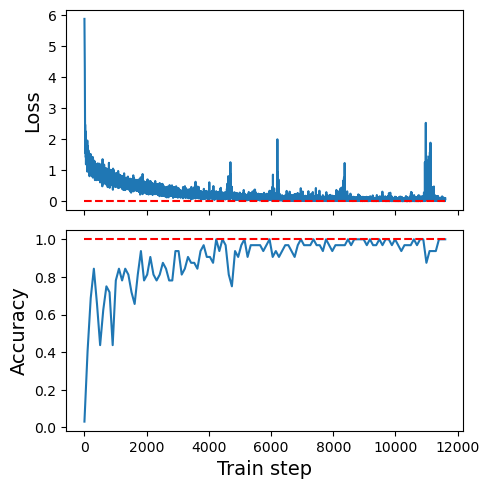

In [21]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Evaluate

In [22]:
dataset._df

,expnum,ra,dec,exptime,filter,propid,program,teff,fwhm,datetime,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff,timestamp,night
0,229250,301.199036,-50.938332,90,g,2012B-0001,survey,0.41,1.15,2013-08-31 23:55:07,139.550003,32.209999,-33.208458,1.18,1.15,0.42,1.26,0.41,1377993307,2013-08-31
1,229251,300.851105,-52.967278,90,g,2012B-0001,survey,0.60,1.18,2013-08-31 23:57:08,143.320007,32.759998,-32.380917,1.19,1.18,0.15,1.23,0.60,1377993428,2013-08-31
2,229252,300.460083,-54.996220,90,g,2012B-0001,survey,0.62,1.17,2013-08-31 23:59:08,146.949997,33.419998,-31.494499,1.20,1.17,-0.07,1.22,0.62,1377993548,2013-08-31
3,229253,300.016754,-57.024887,90,g,2012B-0001,survey,0.52,1.29,2013-09-01 00:01:11,150.449997,34.209999,-30.536041,1.21,1.29,-0.21,1.20,0.52,1377993671,2013-08-31
4,229254,302.722076,-58.040192,90,g,2012B-0001,survey,0.44,1.40,2013-09-01 00:03:13,150.589996,35.759998,-32.738377,1.23,1.40,0.04,1.20,0.44,1377993793,2013-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,229362,324.616028,-53.981499,90,r,2012B-0001,survey,0.76,0.86,2013-09-01 04:20:30,193.940002,24.790001,9.914000,1.10,0.86,0.39,2.94,0.76,1378009230,2013-08-31
112,229363,308.637512,-56.011250,90,i,2012B-0001,survey,1.24,0.84,2013-09-01 04:23:03,208.240005,31.809999,26.498501,1.18,0.84,0.23,6.89,1.24,1378009383,2013-08-31
113,229364,314.232361,-56.010166,90,r,2012B-0001,survey,0.57,0.87,2013-09-01 04:25:11,204.220001,29.870001,21.446125,1.15,0.87,0.48,3.21,0.57,1378009511,2013-08-31
114,229365,314.236420,-56.010414,90,i,2012B-0001,survey,1.10,0.82,2013-09-01 04:27:11,204.580002,30.020000,21.859875,1.15,0.82,0.32,6.94,1.10,1378009631,2013-08-31


In [23]:
dataset.states[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [24]:
dataset.states.shape

torch.Size([116, 9])

In [25]:
import random

In [26]:
eval_actions = []
success_sequence = []
azel_sequence = [(az, el) for az, el in zip (dataset.states[:, 0], dataset.states[:, 1])]

with torch.no_grad():
    for i, state in enumerate(dataset.states):
        q_vals = agent.algorithm.policy_net(state).unsqueeze(0)
        action = torch.argmax(q_vals, dim=1).item()
        eval_actions.append(action)
        
        candidates_in_bin = np.array(dataset.id2azel[action])
        success_sequence.append(azel_sequence[i] in candidates_in_bin)
        dataset.actions

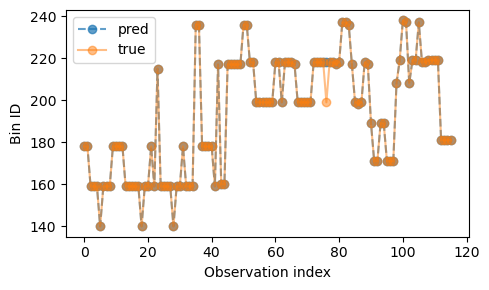

In [29]:
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions

fig, axs = plt.subplots(1, figsize=(5,3))
axs.plot(eval_sequence, marker='o', linestyle='dashed', label='pred', alpha=.7)
axs.plot(target_sequence, marker='o', label='true', alpha=.5)
axs.legend()
axs.set_xlabel('Observation index')
axs.set_ylabel('Bin ID')

# axs[1].plot(eval_sequence - target_sequence, marker='o')
# axs[1].legend()
# axs[1].set_xlabel('obs index')
# axs[1].set_ylabel('pred - true')

fig.tight_layout()
fig.savefig(fig_outdir + 'learned_sequence.png')

In [112]:
from environments import OfflineEnv

env_name = 'OfflineEnv'

gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=OfflineEnv,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)

# for eval step only
env_config = {
    'id': f"gymnasium_env/{env_name}",
    'dataset': dataset
}


env = gym.make(**env_config)
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

AttributeError: 'OfflineDataset' object has no attribute 'reward_func'

In [22]:
agent.evaluate(env=env, num_episodes=1)
with open(outdir + 'eval_metrics.pkl', 'rb') as handle:
    eval_metrics = pickle.load(handle)

100%|██████████| 1/1 [00:00<00:00, 90.72it/s]

terminated at 58
eval_metrics.pkl saved in ../results/None/


In [30]:
target_sequence = dataset._schedule_field_ids[0]
eval_sequence = eval_metrics['observations']['ep-0'][:, 0]

fig, axs = plt.subplots(2)
axs[0].plot(eval_sequence, marker='o', label='pred')
axs[0].plot(target_sequence, marker='o', linestyle='dashed', label='true')
axs[0].legend()
axs[0].set_xlabel('obs index')
axs[0].set_ylabel('field id')

axs[1].plot(eval_sequence - target_sequence, marker='o')
axs[1].legend()
axs[1].set_xlabel('obs index')
axs[1].set_ylabel('pred - true')


fig.savefig(fig_outdir + 'learned_sequence.png')

AttributeError: 'OfflineDataset' object has no attribute '_schedule_field_ids'

# Exp2: Multiple Nights

# Configure model, data selection, and training setup

In [31]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [32]:
num_bins_1d = 19
dataset = OfflineDataset(
    df, 
    num_bins_1d=19, 
    normalize_state=True,
    specific_years=[2013],
    specific_months=[8, 9],
    specific_days=[31, 1, 2],
    # specific_filters=['r', 'g']
)

In [56]:
dataset.n_nights

3

In [33]:
batch_size = 32
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [34]:
"""Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 64,
    'device': device,
    'lr': 2.5e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 80,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'TelescopeEnv-v0'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config):
    exp_name = f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': dataset.normalize_state,
    'outdir': outdir
    }

agent = Agent(**agent_config)



# Visualize dataset in (az, el) and binning sizes

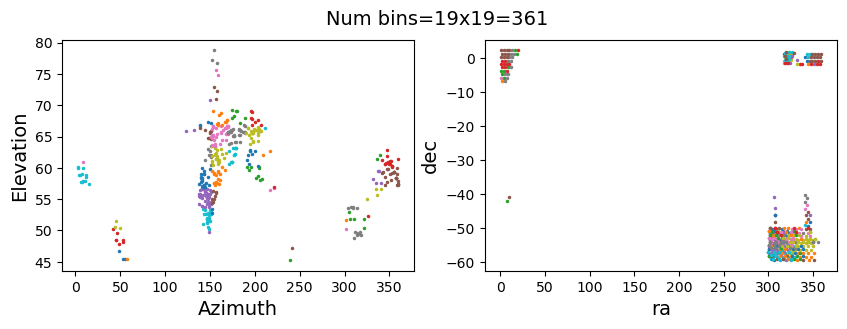

In [35]:
s = 1000/len(dataset)
fig, axs = plt.subplots(1,2, figsize=(10,3))
for bin_id in dataset.id2azel.keys():
    field_ids = np.array(dataset.id2azel[bin_id])
    axs[0].scatter(field_ids[:, 0], field_ids[:, 1], label='bin' + str(bin_id), s=s)
axs[0].set_xlabel('Azimuth', fontsize=14)
axs[0].set_ylabel('Elevation', fontsize=14)

for bin_id in dataset.id2radec.keys():
    field_ids = np.array(dataset.id2radec[bin_id])
    axs[1].scatter(field_ids[:, 0], field_ids[:, 1], label='bin' + str(bin_id), s=s)
axs[1].set_xlabel('ra', fontsize=14)
axs[1].set_ylabel('dec', fontsize=14)

fig.suptitle(f'Num bins={num_bins_1d}x{num_bins_1d}={dataset.num_actions}', fontsize=14)
fig.savefig(fig_outdir + 'plot_observations_in_sky_colored_bins.png')

# Train

In [36]:
start_time = time.time()
"""Train"""
agent.fit(
    dataloader=trainloader,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(f'Total train time = {train_time}s')

  0%|                                                 | 0/35520 [00:00<?, ?it/s]/home/rachel/Projects/survey-ops/notebooks/../survey_ops/src/algorithms.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expert_actions = torch.tensor(expert_actions, device=self.device, dtype=torch.long) # needs to be long for .gather()
/home/rachel/Projects/survey-ops/notebooks/../survey_ops/src/agents.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_obs = torch.tensor(eval_obs, device=self.device)
/home/rachel/Projects/survey-ops/notebooks/../survey_ops/src/agents.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

Train step 0: Accuracy = 0.031, Loss = 5.8675


  0%|▏                                     | 131/35520 [00:00<02:29, 237.15it/s]

Train step 100: Accuracy = 0.469, Loss = 1.6726


  1%|▎                                     | 240/35520 [00:01<02:12, 267.22it/s]

Train step 200: Accuracy = 0.375, Loss = 1.6276


  1%|▍                                     | 356/35520 [00:01<02:03, 283.87it/s]

Train step 300: Accuracy = 0.500, Loss = 1.6833


  1%|▍                                     | 444/35520 [00:01<02:03, 284.89it/s]

Train step 400: Accuracy = 0.656, Loss = 1.1319


  1%|▌                                     | 532/35520 [00:02<02:03, 282.83it/s]

Train step 500: Accuracy = 0.594, Loss = 1.2064


  2%|▋                                     | 654/35520 [00:02<01:58, 295.14it/s]

Train step 600: Accuracy = 0.562, Loss = 1.2460


  2%|▊                                     | 742/35520 [00:02<02:01, 287.13it/s]

Train step 700: Accuracy = 0.562, Loss = 1.2019


  2%|▉                                     | 858/35520 [00:03<02:02, 282.32it/s]

Train step 800: Accuracy = 0.469, Loss = 1.0599


  3%|█                                     | 944/35520 [00:03<02:05, 274.59it/s]

Train step 900: Accuracy = 0.531, Loss = 1.0198


  3%|█                                    | 1058/35520 [00:03<02:03, 278.06it/s]

Train step 1000: Accuracy = 0.688, Loss = 1.1585


  3%|█▏                                   | 1144/35520 [00:04<02:05, 273.67it/s]

Train step 1100: Accuracy = 0.844, Loss = 1.0725


  3%|█▎                                   | 1229/35520 [00:04<02:04, 276.39it/s]

Train step 1200: Accuracy = 0.531, Loss = 0.8382


  4%|█▍                                   | 1341/35520 [00:04<02:05, 273.16it/s]

Train step 1300: Accuracy = 0.438, Loss = 0.8307


  4%|█▌                                   | 1457/35520 [00:05<01:59, 285.06it/s]

Train step 1400: Accuracy = 0.469, Loss = 1.0342


  4%|█▌                                   | 1544/35520 [00:05<02:01, 279.69it/s]

Train step 1500: Accuracy = 0.625, Loss = 0.9748


  5%|█▋                                   | 1628/35520 [00:06<02:06, 268.31it/s]

Train step 1600: Accuracy = 0.594, Loss = 0.8730


  5%|█▊                                   | 1742/35520 [00:06<02:02, 276.55it/s]

Train step 1700: Accuracy = 0.531, Loss = 1.1649


  5%|█▉                                   | 1856/35520 [00:06<02:01, 277.43it/s]

Train step 1800: Accuracy = 0.719, Loss = 1.0069


  5%|██                                   | 1941/35520 [00:07<02:02, 273.05it/s]

Train step 1900: Accuracy = 0.750, Loss = 0.8268


  6%|██▏                                  | 2056/35520 [00:07<01:58, 282.08it/s]

Train step 2000: Accuracy = 0.594, Loss = 1.0590


  6%|██▏                                  | 2143/35520 [00:07<01:58, 282.29it/s]

Train step 2100: Accuracy = 0.469, Loss = 0.9869


  6%|██▎                                  | 2256/35520 [00:08<02:02, 272.03it/s]

Train step 2200: Accuracy = 0.781, Loss = 0.7825


  7%|██▍                                  | 2342/35520 [00:08<01:59, 278.77it/s]

Train step 2300: Accuracy = 0.438, Loss = 0.5441


  7%|██▌                                  | 2458/35520 [00:09<01:56, 284.63it/s]

Train step 2400: Accuracy = 0.594, Loss = 0.8072


  7%|██▋                                  | 2544/35520 [00:09<01:59, 276.46it/s]

Train step 2500: Accuracy = 0.719, Loss = 0.7347


  7%|██▊                                  | 2659/35520 [00:09<01:55, 284.96it/s]

Train step 2600: Accuracy = 0.594, Loss = 0.8652


  8%|██▊                                  | 2749/35520 [00:10<01:53, 289.94it/s]

Train step 2700: Accuracy = 0.500, Loss = 0.9125


  8%|██▉                                  | 2836/35520 [00:10<01:55, 283.85it/s]

Train step 2800: Accuracy = 0.750, Loss = 0.6793


  8%|███                                  | 2952/35520 [00:10<01:54, 283.39it/s]

Train step 2900: Accuracy = 0.719, Loss = 0.6840


  9%|███▏                                 | 3039/35520 [00:11<01:55, 280.40it/s]

Train step 3000: Accuracy = 0.719, Loss = 0.6019


  9%|███▎                                 | 3152/35520 [00:11<01:57, 276.35it/s]

Train step 3100: Accuracy = 0.688, Loss = 0.6951


  9%|███▎                                 | 3236/35520 [00:11<02:00, 268.29it/s]

Train step 3200: Accuracy = 0.656, Loss = 0.6684


  9%|███▍                                 | 3350/35520 [00:12<01:56, 276.93it/s]

Train step 3300: Accuracy = 0.750, Loss = 0.5995


 10%|███▌                                 | 3441/35520 [00:12<01:50, 291.04it/s]

Train step 3400: Accuracy = 0.719, Loss = 0.8259


 10%|███▋                                 | 3532/35520 [00:12<01:49, 292.29it/s]

Train step 3500: Accuracy = 0.594, Loss = 0.5048


 10%|███▊                                 | 3648/35520 [00:13<01:55, 276.07it/s]

Train step 3600: Accuracy = 0.625, Loss = 0.6939


 11%|███▉                                 | 3732/35520 [00:13<01:55, 274.06it/s]

Train step 3700: Accuracy = 0.625, Loss = 0.5611


 11%|████                                 | 3844/35520 [00:13<01:55, 273.56it/s]

Train step 3800: Accuracy = 0.719, Loss = 0.5204


 11%|████                                 | 3928/35520 [00:14<02:00, 261.37it/s]

Train step 3900: Accuracy = 0.750, Loss = 0.9080


 11%|████▏                                | 4037/35520 [00:14<01:56, 269.84it/s]

Train step 4000: Accuracy = 0.656, Loss = 0.6241


 12%|████▎                                | 4154/35520 [00:15<01:50, 284.59it/s]

Train step 4100: Accuracy = 0.656, Loss = 0.7578


 12%|████▍                                | 4243/35520 [00:15<01:47, 290.93it/s]

Train step 4200: Accuracy = 0.688, Loss = 0.7206


 12%|████▌                                | 4333/35520 [00:15<01:45, 294.28it/s]

Train step 4300: Accuracy = 0.781, Loss = 0.6212


 13%|████▋                                | 4453/35520 [00:16<01:45, 294.04it/s]

Train step 4400: Accuracy = 0.688, Loss = 0.7295


 13%|████▋                                | 4543/35520 [00:16<01:45, 294.04it/s]

Train step 4500: Accuracy = 0.812, Loss = 0.5767


 13%|████▊                                | 4634/35520 [00:16<01:44, 294.31it/s]

Train step 4600: Accuracy = 0.719, Loss = 0.6654


 13%|████▉                                | 4754/35520 [00:17<01:44, 293.22it/s]

Train step 4700: Accuracy = 0.750, Loss = 0.8483


 14%|█████                                | 4845/35520 [00:17<01:44, 293.67it/s]

Train step 4800: Accuracy = 0.750, Loss = 0.6142


 14%|█████▏                               | 4935/35520 [00:17<01:45, 288.86it/s]

Train step 4900: Accuracy = 0.625, Loss = 0.6992


 14%|█████▎                               | 5052/35520 [00:18<01:46, 285.39it/s]

Train step 5000: Accuracy = 0.750, Loss = 0.7425


 14%|█████▎                               | 5143/35520 [00:18<01:43, 293.16it/s]

Train step 5100: Accuracy = 0.750, Loss = 0.4278


 15%|█████▍                               | 5232/35520 [00:18<01:46, 284.70it/s]

Train step 5200: Accuracy = 0.688, Loss = 0.7304


 15%|█████▌                               | 5348/35520 [00:19<01:48, 278.83it/s]

Train step 5300: Accuracy = 0.656, Loss = 0.4541


 15%|█████▋                               | 5433/35520 [00:19<01:47, 280.52it/s]

Train step 5400: Accuracy = 0.656, Loss = 0.5195


 16%|█████▊                               | 5549/35520 [00:19<01:51, 267.95it/s]

Train step 5500: Accuracy = 0.750, Loss = 0.3982


 16%|█████▊                               | 5630/35520 [00:20<01:51, 268.17it/s]

Train step 5600: Accuracy = 0.719, Loss = 0.5468


 16%|█████▉                               | 5745/35520 [00:20<01:44, 284.23it/s]

Train step 5700: Accuracy = 0.781, Loss = 0.5607


 16%|██████                               | 5832/35520 [00:21<01:49, 270.88it/s]

Train step 5800: Accuracy = 0.688, Loss = 0.6907


 17%|██████▏                              | 5944/35520 [00:21<01:48, 272.64it/s]

Train step 5900: Accuracy = 0.781, Loss = 0.4731


 17%|██████▎                              | 6031/35520 [00:21<01:44, 281.58it/s]

Train step 6000: Accuracy = 0.750, Loss = 0.4800


 17%|██████▍                              | 6147/35520 [00:22<01:43, 284.04it/s]

Train step 6100: Accuracy = 0.812, Loss = 0.4933


 18%|██████▍                              | 6233/35520 [00:22<01:45, 276.49it/s]

Train step 6200: Accuracy = 0.781, Loss = 0.3924


 18%|██████▌                              | 6348/35520 [00:22<01:48, 267.79it/s]

Train step 6300: Accuracy = 0.844, Loss = 0.5896


 18%|██████▋                              | 6431/35520 [00:23<01:47, 271.01it/s]

Train step 6400: Accuracy = 0.781, Loss = 0.4042


 18%|██████▊                              | 6545/35520 [00:23<01:45, 275.56it/s]

Train step 6500: Accuracy = 0.812, Loss = 0.4684


 19%|██████▉                              | 6632/35520 [00:23<01:42, 282.72it/s]

Train step 6600: Accuracy = 0.750, Loss = 0.5311


 19%|███████                              | 6748/35520 [00:24<01:47, 268.32it/s]

Train step 6700: Accuracy = 0.812, Loss = 0.5136


 19%|███████                              | 6837/35520 [00:24<01:40, 284.19it/s]

Train step 6800: Accuracy = 0.844, Loss = 0.5151


 20%|███████▏                             | 6957/35520 [00:25<01:38, 291.31it/s]

Train step 6900: Accuracy = 0.875, Loss = 0.4735


 20%|███████▎                             | 7047/35520 [00:25<01:38, 288.77it/s]

Train step 7000: Accuracy = 0.562, Loss = 0.6101


 20%|███████▍                             | 7133/35520 [00:25<01:42, 278.23it/s]

Train step 7100: Accuracy = 0.750, Loss = 0.8362


 20%|███████▌                             | 7251/35520 [00:26<01:37, 289.91it/s]

Train step 7200: Accuracy = 0.938, Loss = 0.4882


 21%|███████▋                             | 7341/35520 [00:26<01:36, 291.44it/s]

Train step 7300: Accuracy = 0.750, Loss = 0.3666


 21%|███████▋                             | 7429/35520 [00:26<01:40, 280.06it/s]

Train step 7400: Accuracy = 0.844, Loss = 0.6445


 21%|███████▊                             | 7548/35520 [00:27<01:36, 290.94it/s]

Train step 7500: Accuracy = 0.875, Loss = 0.4253


 22%|███████▉                             | 7638/35520 [00:27<01:35, 290.75it/s]

Train step 7600: Accuracy = 0.812, Loss = 0.7147


 22%|████████                             | 7758/35520 [00:27<01:35, 290.97it/s]

Train step 7700: Accuracy = 0.906, Loss = 0.1458


 22%|████████▏                            | 7846/35520 [00:28<01:38, 280.95it/s]

Train step 7800: Accuracy = 0.875, Loss = 0.2790


 22%|████████▎                            | 7935/35520 [00:28<01:35, 288.52it/s]

Train step 7900: Accuracy = 0.781, Loss = 0.2465


 23%|████████▍                            | 8055/35520 [00:28<01:33, 293.09it/s]

Train step 8000: Accuracy = 0.812, Loss = 0.4252


 23%|████████▍                            | 8144/35520 [00:29<01:35, 286.40it/s]

Train step 8100: Accuracy = 0.781, Loss = 0.3633


 23%|████████▌                            | 8232/35520 [00:29<01:35, 285.82it/s]

Train step 8200: Accuracy = 0.656, Loss = 0.5503


 24%|████████▋                            | 8350/35520 [00:29<01:33, 289.65it/s]

Train step 8300: Accuracy = 0.812, Loss = 0.3222


 24%|████████▊                            | 8441/35520 [00:30<01:32, 292.64it/s]

Train step 8400: Accuracy = 0.844, Loss = 0.3104


 24%|████████▉                            | 8532/35520 [00:30<01:32, 292.74it/s]

Train step 8500: Accuracy = 0.906, Loss = 0.4177


 24%|█████████                            | 8652/35520 [00:30<01:31, 294.12it/s]

Train step 8600: Accuracy = 0.844, Loss = 0.3225


 25%|█████████                            | 8742/35520 [00:31<01:31, 293.96it/s]

Train step 8700: Accuracy = 0.844, Loss = 0.5351


 25%|█████████▏                           | 8831/35520 [00:31<01:32, 289.24it/s]

Train step 8800: Accuracy = 0.844, Loss = 0.3607


 25%|█████████▎                           | 8951/35520 [00:31<01:30, 293.54it/s]

Train step 8900: Accuracy = 0.750, Loss = 0.2974


 25%|█████████▍                           | 9042/35520 [00:32<01:29, 294.45it/s]

Train step 9000: Accuracy = 0.906, Loss = 0.4465


 26%|█████████▌                           | 9132/35520 [00:32<01:29, 293.81it/s]

Train step 9100: Accuracy = 0.875, Loss = 0.2447


 26%|█████████▋                           | 9250/35520 [00:33<01:35, 275.79it/s]

Train step 9200: Accuracy = 0.844, Loss = 0.3648


 26%|█████████▋                           | 9336/35520 [00:33<01:33, 278.99it/s]

Train step 9300: Accuracy = 0.844, Loss = 0.5133


 27%|█████████▊                           | 9454/35520 [00:33<01:32, 280.77it/s]

Train step 9400: Accuracy = 0.875, Loss = 0.2710


 27%|█████████▉                           | 9542/35520 [00:34<01:30, 286.67it/s]

Train step 9500: Accuracy = 0.844, Loss = 0.2370


 27%|██████████                           | 9629/35520 [00:34<01:32, 279.03it/s]

Train step 9600: Accuracy = 0.781, Loss = 0.2933


 27%|██████████▏                          | 9746/35520 [00:34<01:29, 287.54it/s]

Train step 9700: Accuracy = 0.938, Loss = 0.3347


 28%|██████████▏                          | 9834/35520 [00:35<01:29, 285.54it/s]

Train step 9800: Accuracy = 0.844, Loss = 0.3377


 28%|██████████▎                          | 9953/35520 [00:35<01:27, 292.40it/s]

Train step 9900: Accuracy = 0.875, Loss = 0.2096


 28%|██████████▏                         | 10043/35520 [00:35<01:27, 289.53it/s]

Train step 10000: Accuracy = 0.812, Loss = 0.5722


 29%|██████████▎                         | 10132/35520 [00:36<01:27, 291.71it/s]

Train step 10100: Accuracy = 0.844, Loss = 0.3201


 29%|██████████▍                         | 10252/35520 [00:36<01:26, 292.91it/s]

Train step 10200: Accuracy = 0.906, Loss = 0.4479


 29%|██████████▍                         | 10341/35520 [00:36<01:27, 287.87it/s]

Train step 10300: Accuracy = 0.938, Loss = 0.3707


 29%|██████████▌                         | 10432/35520 [00:37<01:25, 293.74it/s]

Train step 10400: Accuracy = 0.875, Loss = 0.4131


 30%|██████████▋                         | 10549/35520 [00:37<01:30, 276.02it/s]

Train step 10500: Accuracy = 0.906, Loss = 0.2307


 30%|██████████▊                         | 10633/35520 [00:37<01:29, 276.57it/s]

Train step 10600: Accuracy = 0.844, Loss = 0.2454


 30%|██████████▉                         | 10749/35520 [00:38<01:27, 281.56it/s]

Train step 10700: Accuracy = 0.906, Loss = 0.4666


 31%|██████████▉                         | 10836/35520 [00:38<01:27, 281.60it/s]

Train step 10800: Accuracy = 0.906, Loss = 0.2485


 31%|███████████                         | 10953/35520 [00:39<01:27, 280.31it/s]

Train step 10900: Accuracy = 0.750, Loss = 0.1901


 31%|███████████▏                        | 11042/35520 [00:39<01:25, 287.86it/s]

Train step 11000: Accuracy = 0.875, Loss = 0.2985


 31%|███████████▎                        | 11129/35520 [00:39<01:27, 279.83it/s]

Train step 11100: Accuracy = 0.906, Loss = 0.3512


 32%|███████████▍                        | 11248/35520 [00:40<01:23, 290.18it/s]

Train step 11200: Accuracy = 0.906, Loss = 0.2461


 32%|███████████▍                        | 11338/35520 [00:40<01:22, 293.10it/s]

Train step 11300: Accuracy = 0.906, Loss = 0.2088


 32%|███████████▌                        | 11458/35520 [00:40<01:21, 295.17it/s]

Train step 11400: Accuracy = 0.906, Loss = 0.2693


 33%|███████████▋                        | 11548/35520 [00:41<01:21, 294.74it/s]

Train step 11500: Accuracy = 0.812, Loss = 0.2826


 33%|███████████▊                        | 11638/35520 [00:41<01:21, 294.24it/s]

Train step 11600: Accuracy = 0.875, Loss = 0.2726


 33%|███████████▉                        | 11758/35520 [00:41<01:21, 293.12it/s]

Train step 11700: Accuracy = 0.938, Loss = 0.2887


 33%|████████████                        | 11847/35520 [00:42<01:23, 282.04it/s]

Train step 11800: Accuracy = 0.875, Loss = 0.4790


 34%|████████████                        | 11933/35520 [00:42<01:24, 279.11it/s]

Train step 11900: Accuracy = 0.938, Loss = 0.1685


 34%|████████████▏                       | 12049/35520 [00:42<01:23, 282.18it/s]

Train step 12000: Accuracy = 0.875, Loss = 0.3528


 34%|████████████▎                       | 12136/35520 [00:43<01:23, 280.02it/s]

Train step 12100: Accuracy = 0.969, Loss = 0.1924


 34%|████████████▍                       | 12248/35520 [00:43<01:27, 265.36it/s]

Train step 12200: Accuracy = 0.906, Loss = 0.3674


 35%|████████████▍                       | 12333/35520 [00:43<01:24, 274.69it/s]

Train step 12300: Accuracy = 0.781, Loss = 0.1779


 35%|████████████▌                       | 12445/35520 [00:44<01:24, 272.71it/s]

Train step 12400: Accuracy = 0.906, Loss = 0.1832


 35%|████████████▋                       | 12529/35520 [00:44<01:25, 269.76it/s]

Train step 12500: Accuracy = 0.938, Loss = 0.3380


 36%|████████████▊                       | 12638/35520 [00:45<01:26, 265.17it/s]

Train step 12600: Accuracy = 0.969, Loss = 0.2177


 36%|████████████▉                       | 12750/35520 [00:45<01:23, 272.35it/s]

Train step 12700: Accuracy = 0.938, Loss = 0.2195


 36%|█████████████                       | 12836/35520 [00:45<01:21, 276.90it/s]

Train step 12800: Accuracy = 0.906, Loss = 0.2627


 36%|█████████████                       | 12948/35520 [00:46<01:23, 270.88it/s]

Train step 12900: Accuracy = 0.906, Loss = 0.2796


 37%|█████████████▏                      | 13031/35520 [00:46<01:24, 266.71it/s]

Train step 13000: Accuracy = 0.812, Loss = 0.2118


 37%|█████████████▎                      | 13144/35520 [00:46<01:23, 269.29it/s]

Train step 13100: Accuracy = 0.969, Loss = 0.2376


 37%|█████████████▍                      | 13257/35520 [00:47<01:21, 274.73it/s]

Train step 13200: Accuracy = 0.969, Loss = 0.1510


 38%|█████████████▌                      | 13342/35520 [00:47<01:19, 277.82it/s]

Train step 13300: Accuracy = 1.000, Loss = 0.1495


 38%|█████████████▋                      | 13454/35520 [00:48<01:20, 274.15it/s]

Train step 13400: Accuracy = 0.938, Loss = 0.2129


 38%|█████████████▋                      | 13538/35520 [00:48<01:21, 269.07it/s]

Train step 13500: Accuracy = 0.875, Loss = 0.2479


 38%|█████████████▊                      | 13654/35520 [00:48<01:17, 282.39it/s]

Train step 13600: Accuracy = 0.969, Loss = 0.1821


 39%|█████████████▉                      | 13740/35520 [00:49<01:20, 271.98it/s]

Train step 13700: Accuracy = 0.875, Loss = 0.3091


 39%|██████████████                      | 13856/35520 [00:49<01:16, 282.82it/s]

Train step 13800: Accuracy = 0.969, Loss = 0.1493


 39%|██████████████▏                     | 13940/35520 [00:49<01:20, 268.35it/s]

Train step 13900: Accuracy = 0.938, Loss = 0.1383


 40%|██████████████▏                     | 14051/35520 [00:50<01:19, 270.34it/s]

Train step 14000: Accuracy = 0.969, Loss = 0.2309


 40%|██████████████▎                     | 14133/35520 [00:50<01:20, 266.62it/s]

Train step 14100: Accuracy = 1.000, Loss = 0.1561


 40%|██████████████▍                     | 14240/35520 [00:50<01:22, 258.02it/s]

Train step 14200: Accuracy = 0.938, Loss = 0.1622


 40%|██████████████▌                     | 14354/35520 [00:51<01:16, 276.84it/s]

Train step 14300: Accuracy = 0.969, Loss = 0.1820


 41%|██████████████▋                     | 14439/35520 [00:51<01:17, 270.63it/s]

Train step 14400: Accuracy = 1.000, Loss = 0.1624


 41%|██████████████▋                     | 14548/35520 [00:52<01:21, 258.02it/s]

Train step 14500: Accuracy = 1.000, Loss = 0.1949


 41%|██████████████▊                     | 14627/35520 [00:52<01:23, 251.45it/s]

Train step 14600: Accuracy = 0.906, Loss = 0.2926


 41%|██████████████▉                     | 14733/35520 [00:52<01:21, 254.05it/s]

Train step 14700: Accuracy = 0.906, Loss = 0.2165


 42%|███████████████                     | 14839/35520 [00:53<01:22, 252.20it/s]

Train step 14800: Accuracy = 0.938, Loss = 0.4592


 42%|███████████████▏                    | 14952/35520 [00:53<01:16, 269.45it/s]

Train step 14900: Accuracy = 0.938, Loss = 0.2576


 42%|███████████████▏                    | 15039/35520 [00:53<01:13, 279.46it/s]

Train step 15000: Accuracy = 0.938, Loss = 0.2375


 43%|███████████████▎                    | 15158/35520 [00:54<01:11, 286.06it/s]

Train step 15100: Accuracy = 0.969, Loss = 0.2576


 43%|███████████████▍                    | 15242/35520 [00:54<01:17, 260.03it/s]

Train step 15200: Accuracy = 0.844, Loss = 0.1966


 43%|███████████████▌                    | 15352/35520 [00:55<01:16, 262.99it/s]

Train step 15300: Accuracy = 0.938, Loss = 0.2985


 43%|███████████████▋                    | 15433/35520 [00:55<01:16, 262.98it/s]

Train step 15400: Accuracy = 0.906, Loss = 0.1536


 44%|███████████████▊                    | 15544/35520 [00:55<01:14, 269.62it/s]

Train step 15500: Accuracy = 1.000, Loss = 0.1759


 44%|███████████████▊                    | 15628/35520 [00:56<01:13, 272.32it/s]

Train step 15600: Accuracy = 0.938, Loss = 0.1479


 44%|███████████████▉                    | 15708/35520 [00:56<01:33, 212.89it/s]

Train step 15700: Accuracy = 0.875, Loss = 0.1682


 45%|████████████████                    | 15839/35520 [00:57<01:25, 229.38it/s]

Train step 15800: Accuracy = 0.906, Loss = 0.1272


 45%|████████████████▏                   | 15942/35520 [00:57<01:18, 247.92it/s]

Train step 15900: Accuracy = 0.969, Loss = 0.1257


 45%|████████████████▎                   | 16043/35520 [00:57<01:20, 242.53it/s]

Train step 16000: Accuracy = 0.969, Loss = 0.1364


 45%|████████████████▎                   | 16132/35520 [00:58<01:10, 276.01it/s]

Train step 16100: Accuracy = 0.875, Loss = 0.1349


 46%|████████████████▍                   | 16246/35520 [00:58<01:10, 274.91it/s]

Train step 16200: Accuracy = 0.969, Loss = 0.2650


 46%|████████████████▌                   | 16331/35520 [00:59<01:13, 259.33it/s]

Train step 16300: Accuracy = 0.938, Loss = 0.1769


 46%|████████████████▋                   | 16438/35520 [00:59<01:14, 255.83it/s]

Train step 16400: Accuracy = 0.938, Loss = 0.2302


 47%|████████████████▊                   | 16559/35520 [00:59<01:05, 288.57it/s]

Train step 16500: Accuracy = 0.938, Loss = 0.1347


 47%|████████████████▊                   | 16649/35520 [01:00<01:04, 292.19it/s]

Train step 16600: Accuracy = 0.938, Loss = 0.0756


 47%|████████████████▉                   | 16736/35520 [01:00<01:09, 271.15it/s]

Train step 16700: Accuracy = 1.000, Loss = 0.1707


 47%|█████████████████                   | 16856/35520 [01:00<01:03, 292.30it/s]

Train step 16800: Accuracy = 0.969, Loss = 0.2112


 48%|█████████████████▏                  | 16947/35520 [01:01<01:02, 298.66it/s]

Train step 16900: Accuracy = 0.875, Loss = 0.3257


 48%|█████████████████▎                  | 17040/35520 [01:01<01:01, 299.51it/s]

Train step 17000: Accuracy = 1.000, Loss = 0.1570


 48%|█████████████████▎                  | 17133/35520 [01:01<01:01, 299.53it/s]

Train step 17100: Accuracy = 0.969, Loss = 0.2124


 49%|█████████████████▍                  | 17256/35520 [01:02<01:01, 297.00it/s]

Train step 17200: Accuracy = 0.969, Loss = 0.1064


 49%|█████████████████▌                  | 17347/35520 [01:02<01:00, 298.47it/s]

Train step 17300: Accuracy = 0.969, Loss = 0.0861


 49%|█████████████████▋                  | 17438/35520 [01:02<01:01, 295.98it/s]

Train step 17400: Accuracy = 0.906, Loss = 0.1717


 49%|█████████████████▊                  | 17560/35520 [01:03<00:59, 299.84it/s]

Train step 17500: Accuracy = 0.938, Loss = 0.1964


 50%|█████████████████▉                  | 17653/35520 [01:03<00:59, 301.98it/s]

Train step 17600: Accuracy = 0.875, Loss = 0.2096


 50%|█████████████████▉                  | 17744/35520 [01:03<00:59, 296.91it/s]

Train step 17700: Accuracy = 0.969, Loss = 0.1354


 50%|██████████████████                  | 17834/35520 [01:04<00:59, 295.92it/s]

Train step 17800: Accuracy = 0.844, Loss = 0.2603


 51%|██████████████████▏                 | 17954/35520 [01:04<00:59, 294.94it/s]

Train step 17900: Accuracy = 0.969, Loss = 0.3059


 51%|██████████████████▎                 | 18044/35520 [01:04<01:00, 286.91it/s]

Train step 18000: Accuracy = 1.000, Loss = 0.2056


 51%|██████████████████▍                 | 18130/35520 [01:05<01:03, 273.49it/s]

Train step 18100: Accuracy = 0.938, Loss = 0.2383


 51%|██████████████████▍                 | 18248/35520 [01:05<01:00, 287.52it/s]

Train step 18200: Accuracy = 0.906, Loss = 0.1281


 52%|██████████████████▌                 | 18338/35520 [01:05<00:58, 292.93it/s]

Train step 18300: Accuracy = 0.938, Loss = 0.1762


 52%|██████████████████▋                 | 18460/35520 [01:06<00:57, 298.34it/s]

Train step 18400: Accuracy = 0.969, Loss = 0.0870


 52%|██████████████████▊                 | 18553/35520 [01:06<00:56, 300.47it/s]

Train step 18500: Accuracy = 0.875, Loss = 0.1071


 52%|██████████████████▉                 | 18646/35520 [01:06<00:55, 301.99it/s]

Train step 18600: Accuracy = 0.969, Loss = 0.1650


 53%|██████████████████▉                 | 18739/35520 [01:07<00:55, 300.02it/s]

Train step 18700: Accuracy = 1.000, Loss = 0.0710


 53%|███████████████████                 | 18831/35520 [01:07<00:55, 299.14it/s]

Train step 18800: Accuracy = 0.906, Loss = 0.1194


 53%|███████████████████▏                | 18951/35520 [01:08<00:57, 290.51it/s]

Train step 18900: Accuracy = 0.844, Loss = 0.3373


 54%|███████████████████▎                | 19042/35520 [01:08<00:55, 296.36it/s]

Train step 19000: Accuracy = 0.938, Loss = 0.1307


 54%|███████████████████▍                | 19134/35520 [01:08<00:54, 300.14it/s]

Train step 19100: Accuracy = 0.969, Loss = 0.1033


 54%|███████████████████▌                | 19258/35520 [01:09<00:54, 300.75it/s]

Train step 19200: Accuracy = 0.938, Loss = 0.1113


 54%|███████████████████▌                | 19349/35520 [01:09<00:55, 290.63it/s]

Train step 19300: Accuracy = 0.938, Loss = 0.0611


 55%|███████████████████▋                | 19442/35520 [01:09<00:53, 299.01it/s]

Train step 19400: Accuracy = 1.000, Loss = 0.1629


 55%|███████████████████▊                | 19534/35520 [01:09<00:53, 301.13it/s]

Train step 19500: Accuracy = 1.000, Loss = 0.2347


 55%|███████████████████▉                | 19658/35520 [01:10<00:52, 301.33it/s]

Train step 19600: Accuracy = 0.938, Loss = 0.1415


 56%|████████████████████                | 19751/35520 [01:10<00:52, 302.16it/s]

Train step 19700: Accuracy = 0.938, Loss = 0.0808


 56%|████████████████████                | 19844/35520 [01:10<00:52, 300.84it/s]

Train step 19800: Accuracy = 1.000, Loss = 0.1928


 56%|████████████████████▏               | 19937/35520 [01:11<00:51, 300.98it/s]

Train step 19900: Accuracy = 1.000, Loss = 0.0677


 56%|████████████████████▎               | 20058/35520 [01:11<00:53, 290.26it/s]

Train step 20000: Accuracy = 0.875, Loss = 0.1223


 57%|████████████████████▍               | 20149/35520 [01:12<00:51, 297.35it/s]

Train step 20100: Accuracy = 0.875, Loss = 0.0687


 57%|████████████████████▌               | 20241/35520 [01:12<00:51, 299.08it/s]

Train step 20200: Accuracy = 0.906, Loss = 0.2471


 57%|████████████████████▌               | 20334/35520 [01:12<00:50, 300.38it/s]

Train step 20300: Accuracy = 1.000, Loss = 0.1608


 58%|████████████████████▋               | 20458/35520 [01:13<00:50, 299.21it/s]

Train step 20400: Accuracy = 0.938, Loss = 0.1606


 58%|████████████████████▊               | 20551/35520 [01:13<00:50, 299.17it/s]

Train step 20500: Accuracy = 0.969, Loss = 0.0438


 58%|████████████████████▉               | 20643/35520 [01:13<00:49, 301.33it/s]

Train step 20600: Accuracy = 1.000, Loss = 0.0672


 58%|█████████████████████               | 20735/35520 [01:13<00:50, 291.98it/s]

Train step 20700: Accuracy = 1.000, Loss = 0.0633


 59%|█████████████████████▏              | 20852/35520 [01:14<00:54, 270.45it/s]

Train step 20800: Accuracy = 1.000, Loss = 0.0752


 59%|█████████████████████▏              | 20941/35520 [01:14<00:50, 286.96it/s]

Train step 20900: Accuracy = 1.000, Loss = 0.0511


 59%|█████████████████████▎              | 21033/35520 [01:15<00:49, 294.49it/s]

Train step 21000: Accuracy = 0.969, Loss = 0.1902


 60%|█████████████████████▍              | 21154/35520 [01:15<00:48, 294.24it/s]

Train step 21100: Accuracy = 1.000, Loss = 0.1123


 60%|█████████████████████▌              | 21245/35520 [01:15<00:48, 294.58it/s]

Train step 21200: Accuracy = 0.938, Loss = 0.2015


 60%|█████████████████████▌              | 21335/35520 [01:16<00:48, 292.73it/s]

Train step 21300: Accuracy = 1.000, Loss = 0.1246


 60%|█████████████████████▋              | 21456/35520 [01:16<00:47, 294.72it/s]

Train step 21400: Accuracy = 1.000, Loss = 0.2866


 61%|█████████████████████▊              | 21546/35520 [01:16<00:48, 288.73it/s]

Train step 21500: Accuracy = 1.000, Loss = 0.0870


 61%|█████████████████████▉              | 21635/35520 [01:17<00:47, 291.76it/s]

Train step 21600: Accuracy = 0.906, Loss = 0.0750


 61%|██████████████████████              | 21755/35520 [01:17<00:46, 293.91it/s]

Train step 21700: Accuracy = 0.969, Loss = 0.0601


 62%|██████████████████████▏             | 21846/35520 [01:17<00:47, 289.03it/s]

Train step 21800: Accuracy = 0.906, Loss = 0.3502


 62%|██████████████████████▏             | 21935/35520 [01:18<00:48, 282.38it/s]

Train step 21900: Accuracy = 0.938, Loss = 0.1943


 62%|██████████████████████▎             | 22057/35520 [01:18<00:46, 289.79it/s]

Train step 22000: Accuracy = 0.844, Loss = 0.0874


 62%|██████████████████████▍             | 22148/35520 [01:18<00:45, 291.05it/s]

Train step 22100: Accuracy = 0.938, Loss = 0.1122


 63%|██████████████████████▌             | 22238/35520 [01:19<00:45, 293.58it/s]

Train step 22200: Accuracy = 0.969, Loss = 0.1758


 63%|██████████████████████▋             | 22358/35520 [01:19<00:44, 295.95it/s]

Train step 22300: Accuracy = 0.906, Loss = 0.1643


 63%|██████████████████████▊             | 22448/35520 [01:19<00:44, 291.28it/s]

Train step 22400: Accuracy = 0.938, Loss = 0.0333


 63%|██████████████████████▊             | 22538/35520 [01:20<00:44, 293.73it/s]

Train step 22500: Accuracy = 0.969, Loss = 0.2055


 64%|██████████████████████▉             | 22660/35520 [01:20<00:43, 298.32it/s]

Train step 22600: Accuracy = 0.938, Loss = 0.0747


 64%|███████████████████████             | 22751/35520 [01:20<00:42, 297.30it/s]

Train step 22700: Accuracy = 0.969, Loss = 0.1025


 64%|███████████████████████▏            | 22843/35520 [01:21<00:42, 299.72it/s]

Train step 22800: Accuracy = 1.000, Loss = 0.0773


 65%|███████████████████████▏            | 22936/35520 [01:21<00:42, 298.89it/s]

Train step 22900: Accuracy = 0.938, Loss = 0.2074


 65%|███████████████████████▎            | 23056/35520 [01:21<00:41, 297.47it/s]

Train step 23000: Accuracy = 0.969, Loss = 0.1133


 65%|███████████████████████▍            | 23148/35520 [01:22<00:41, 300.32it/s]

Train step 23100: Accuracy = 0.906, Loss = 0.0490


 65%|███████████████████████▌            | 23241/35520 [01:22<00:40, 300.88it/s]

Train step 23200: Accuracy = 0.906, Loss = 0.0133


 66%|███████████████████████▋            | 23334/35520 [01:22<00:40, 300.18it/s]

Train step 23300: Accuracy = 0.969, Loss = 0.0373


 66%|███████████████████████▊            | 23457/35520 [01:23<00:40, 296.13it/s]

Train step 23400: Accuracy = 1.000, Loss = 0.1572


 66%|███████████████████████▊            | 23547/35520 [01:23<00:41, 291.94it/s]

Train step 23500: Accuracy = 1.000, Loss = 0.0952


 67%|███████████████████████▉            | 23637/35520 [01:23<00:40, 290.70it/s]

Train step 23600: Accuracy = 0.969, Loss = 0.0263


 67%|████████████████████████            | 23729/35520 [01:24<00:40, 292.57it/s]

Train step 23700: Accuracy = 1.000, Loss = 0.0613


 67%|████████████████████████▏           | 23846/35520 [01:24<00:41, 283.94it/s]

Train step 23800: Accuracy = 0.938, Loss = 0.0244


 67%|████████████████████████▎           | 23937/35520 [01:24<00:39, 293.95it/s]

Train step 23900: Accuracy = 0.938, Loss = 0.0990


 68%|████████████████████████▍           | 24060/35520 [01:25<00:38, 298.76it/s]

Train step 24000: Accuracy = 0.875, Loss = 0.0173


 68%|████████████████████████▍           | 24152/35520 [01:25<00:37, 299.68it/s]

Train step 24100: Accuracy = 0.969, Loss = 0.1166


 68%|████████████████████████▌           | 24245/35520 [01:25<00:37, 301.74it/s]

Train step 24200: Accuracy = 0.938, Loss = 0.1069


 69%|████████████████████████▋           | 24338/35520 [01:26<00:37, 301.67it/s]

Train step 24300: Accuracy = 0.812, Loss = 0.1122


 69%|████████████████████████▊           | 24431/35520 [01:26<00:36, 300.53it/s]

Train step 24400: Accuracy = 0.969, Loss = 0.3553


 69%|████████████████████████▉           | 24555/35520 [01:27<00:36, 301.39it/s]

Train step 24500: Accuracy = 0.969, Loss = 0.0918


 69%|████████████████████████▉           | 24648/35520 [01:27<00:35, 302.17it/s]

Train step 24600: Accuracy = 1.000, Loss = 0.1475


 70%|█████████████████████████           | 24741/35520 [01:27<00:35, 299.89it/s]

Train step 24700: Accuracy = 1.000, Loss = 0.0948


 70%|█████████████████████████▏          | 24831/35520 [01:27<00:37, 288.84it/s]

Train step 24800: Accuracy = 0.906, Loss = 0.1712


 70%|█████████████████████████▎          | 24953/35520 [01:28<00:35, 299.14it/s]

Train step 24900: Accuracy = 0.938, Loss = 0.0532


 71%|█████████████████████████▍          | 25045/35520 [01:28<00:34, 299.52it/s]

Train step 25000: Accuracy = 0.969, Loss = 0.0675


 71%|█████████████████████████▍          | 25137/35520 [01:28<00:34, 298.60it/s]

Train step 25100: Accuracy = 0.969, Loss = 0.1319


 71%|█████████████████████████▌          | 25259/35520 [01:29<00:34, 299.67it/s]

Train step 25200: Accuracy = 1.000, Loss = 0.0929


 71%|█████████████████████████▋          | 25352/35520 [01:29<00:34, 298.79it/s]

Train step 25300: Accuracy = 1.000, Loss = 0.0537


 72%|█████████████████████████▊          | 25443/35520 [01:29<00:33, 298.66it/s]

Train step 25400: Accuracy = 0.969, Loss = 0.0500


 72%|█████████████████████████▉          | 25535/35520 [01:30<00:33, 301.14it/s]

Train step 25500: Accuracy = 0.938, Loss = 0.1672


 72%|██████████████████████████          | 25658/35520 [01:30<00:33, 293.00it/s]

Train step 25600: Accuracy = 0.906, Loss = 0.1433


 72%|██████████████████████████          | 25748/35520 [01:31<00:33, 290.04it/s]

Train step 25700: Accuracy = 0.906, Loss = 0.0333


 73%|██████████████████████████▏         | 25840/35520 [01:31<00:32, 296.22it/s]

Train step 25800: Accuracy = 0.969, Loss = 0.0268


 73%|██████████████████████████▎         | 25960/35520 [01:31<00:32, 295.76it/s]

Train step 25900: Accuracy = 0.938, Loss = 0.1844


 73%|██████████████████████████▍         | 26050/35520 [01:32<00:32, 290.39it/s]

Train step 26000: Accuracy = 0.969, Loss = 0.0212


 74%|██████████████████████████▍         | 26141/35520 [01:32<00:32, 290.75it/s]

Train step 26100: Accuracy = 0.969, Loss = 0.2438


 74%|██████████████████████████▌         | 26231/35520 [01:32<00:31, 292.71it/s]

Train step 26200: Accuracy = 0.969, Loss = 0.1824


 74%|██████████████████████████▋         | 26322/35520 [01:32<00:31, 288.53it/s]

Train step 26300: Accuracy = 0.969, Loss = 0.2072


 74%|██████████████████████████▊         | 26438/35520 [01:33<00:33, 271.70it/s]

Train step 26400: Accuracy = 1.000, Loss = 0.0264


 75%|██████████████████████████▉         | 26557/35520 [01:33<00:31, 288.42it/s]

Train step 26500: Accuracy = 0.969, Loss = 0.2927


 75%|███████████████████████████         | 26648/35520 [01:34<00:29, 296.59it/s]

Train step 26600: Accuracy = 1.000, Loss = 0.1309


 75%|███████████████████████████         | 26739/35520 [01:34<00:29, 294.98it/s]

Train step 26700: Accuracy = 1.000, Loss = 0.0765


 76%|███████████████████████████▏        | 26859/35520 [01:34<00:29, 292.20it/s]

Train step 26800: Accuracy = 0.938, Loss = 0.0731


 76%|███████████████████████████▎        | 26950/35520 [01:35<00:29, 295.43it/s]

Train step 26900: Accuracy = 0.969, Loss = 0.2390


 76%|███████████████████████████▍        | 27042/35520 [01:35<00:28, 300.41it/s]

Train step 27000: Accuracy = 1.000, Loss = 0.0170


 76%|███████████████████████████▌        | 27135/35520 [01:35<00:27, 301.46it/s]

Train step 27100: Accuracy = 0.938, Loss = 0.0919


 77%|███████████████████████████▋        | 27259/35520 [01:36<00:27, 302.86it/s]

Train step 27200: Accuracy = 0.906, Loss = 0.1529


 77%|███████████████████████████▋        | 27352/35520 [01:36<00:26, 302.54it/s]

Train step 27300: Accuracy = 0.969, Loss = 0.0805


 77%|███████████████████████████▊        | 27445/35520 [01:36<00:26, 299.26it/s]

Train step 27400: Accuracy = 0.969, Loss = 0.0484


 78%|███████████████████████████▉        | 27535/35520 [01:37<00:28, 285.06it/s]

Train step 27500: Accuracy = 0.969, Loss = 0.1035


 78%|████████████████████████████        | 27656/35520 [01:37<00:26, 296.12it/s]

Train step 27600: Accuracy = 1.000, Loss = 0.2279


 78%|████████████████████████████        | 27746/35520 [01:37<00:26, 294.88it/s]

Train step 27700: Accuracy = 0.938, Loss = 0.0726


 78%|████████████████████████████▏       | 27837/35520 [01:38<00:25, 296.02it/s]

Train step 27800: Accuracy = 0.969, Loss = 0.1237


 79%|████████████████████████████▎       | 27961/35520 [01:38<00:25, 299.89it/s]

Train step 27900: Accuracy = 1.000, Loss = 0.2387


 79%|████████████████████████████▍       | 28053/35520 [01:38<00:25, 293.92it/s]

Train step 28000: Accuracy = 0.938, Loss = 0.1918


 79%|████████████████████████████▌       | 28144/35520 [01:39<00:24, 297.63it/s]

Train step 28100: Accuracy = 0.969, Loss = 0.0308


 79%|████████████████████████████▌       | 28236/35520 [01:39<00:24, 299.47it/s]

Train step 28200: Accuracy = 0.969, Loss = 0.0340


 80%|████████████████████████████▋       | 28358/35520 [01:39<00:24, 298.10it/s]

Train step 28300: Accuracy = 1.000, Loss = 0.1978


 80%|████████████████████████████▊       | 28449/35520 [01:40<00:23, 298.76it/s]

Train step 28400: Accuracy = 0.969, Loss = 0.0279


 80%|████████████████████████████▉       | 28542/35520 [01:40<00:23, 300.26it/s]

Train step 28500: Accuracy = 0.906, Loss = 0.2244


 81%|█████████████████████████████       | 28635/35520 [01:40<00:22, 301.67it/s]

Train step 28600: Accuracy = 0.906, Loss = 0.0112


 81%|█████████████████████████████       | 28728/35520 [01:41<00:22, 301.54it/s]

Train step 28700: Accuracy = 0.969, Loss = 0.0387


 81%|█████████████████████████████▏      | 28845/35520 [01:41<00:24, 272.14it/s]

Train step 28800: Accuracy = 0.938, Loss = 0.1511


 81%|█████████████████████████████▎      | 28936/35520 [01:41<00:22, 288.75it/s]

Train step 28900: Accuracy = 0.938, Loss = 0.1713


 82%|█████████████████████████████▍      | 29057/35520 [01:42<00:23, 279.77it/s]

Train step 29000: Accuracy = 1.000, Loss = 0.0938


 82%|█████████████████████████████▌      | 29149/35520 [01:42<00:21, 291.43it/s]

Train step 29100: Accuracy = 1.000, Loss = 0.0553


 82%|█████████████████████████████▋      | 29239/35520 [01:43<00:21, 292.60it/s]

Train step 29200: Accuracy = 0.906, Loss = 0.4210


 83%|█████████████████████████████▋      | 29330/35520 [01:43<00:21, 293.17it/s]

Train step 29300: Accuracy = 0.938, Loss = 0.0355


 83%|█████████████████████████████▊      | 29450/35520 [01:43<00:21, 287.75it/s]

Train step 29400: Accuracy = 0.938, Loss = 0.1462


 83%|█████████████████████████████▉      | 29535/35520 [01:44<00:22, 270.19it/s]

Train step 29500: Accuracy = 0.969, Loss = 0.2047


 83%|██████████████████████████████      | 29650/35520 [01:44<00:21, 274.08it/s]

Train step 29600: Accuracy = 0.969, Loss = 0.0907


 84%|██████████████████████████████▏     | 29740/35520 [01:44<00:19, 289.15it/s]

Train step 29700: Accuracy = 0.969, Loss = 0.1229


 84%|██████████████████████████████▏     | 29831/35520 [01:45<00:19, 286.11it/s]

Train step 29800: Accuracy = 0.938, Loss = 0.0225


 84%|██████████████████████████████▎     | 29947/35520 [01:45<00:20, 269.44it/s]

Train step 29900: Accuracy = 1.000, Loss = 0.0451


 85%|██████████████████████████████▍     | 30039/35520 [01:45<00:18, 288.88it/s]

Train step 30000: Accuracy = 0.969, Loss = 0.0498


 85%|██████████████████████████████▌     | 30130/35520 [01:46<00:18, 296.63it/s]

Train step 30100: Accuracy = 0.969, Loss = 0.0676


 85%|██████████████████████████████▋     | 30244/35520 [01:46<00:23, 227.60it/s]

Train step 30200: Accuracy = 0.906, Loss = 0.0790


 85%|██████████████████████████████▋     | 30333/35520 [01:47<00:19, 264.87it/s]

Train step 30300: Accuracy = 0.969, Loss = 0.0346


 86%|██████████████████████████████▊     | 30449/35520 [01:47<00:18, 281.21it/s]

Train step 30400: Accuracy = 1.000, Loss = 0.0949


 86%|██████████████████████████████▉     | 30532/35520 [01:47<00:19, 256.97it/s]

Train step 30500: Accuracy = 0.969, Loss = 0.0713


 86%|███████████████████████████████     | 30638/35520 [01:48<00:19, 246.15it/s]

Train step 30600: Accuracy = 0.938, Loss = 0.2969


 87%|███████████████████████████████▏    | 30751/35520 [01:48<00:17, 268.52it/s]

Train step 30700: Accuracy = 0.906, Loss = 0.0237


 87%|███████████████████████████████▎    | 30836/35520 [01:48<00:16, 277.44it/s]

Train step 30800: Accuracy = 0.969, Loss = 0.2211


 87%|███████████████████████████████▎    | 30950/35520 [01:49<00:16, 269.16it/s]

Train step 30900: Accuracy = 0.938, Loss = 0.0680


 87%|███████████████████████████████▍    | 31034/35520 [01:49<00:17, 263.27it/s]

Train step 31000: Accuracy = 1.000, Loss = 0.1236


 88%|███████████████████████████████▌    | 31141/35520 [01:50<00:17, 255.84it/s]

Train step 31100: Accuracy = 1.000, Loss = 0.0326


 88%|███████████████████████████████▋    | 31254/35520 [01:50<00:15, 267.57it/s]

Train step 31200: Accuracy = 0.906, Loss = 0.1440


 88%|███████████████████████████████▊    | 31339/35520 [01:50<00:15, 269.55it/s]

Train step 31300: Accuracy = 0.938, Loss = 0.0363


 89%|███████████████████████████████▉    | 31450/35520 [01:51<00:15, 265.10it/s]

Train step 31400: Accuracy = 0.938, Loss = 0.0886


 89%|███████████████████████████████▉    | 31535/35520 [01:51<00:14, 272.41it/s]

Train step 31500: Accuracy = 0.969, Loss = 0.2648


 89%|████████████████████████████████    | 31647/35520 [01:51<00:14, 266.69it/s]

Train step 31600: Accuracy = 1.000, Loss = 0.2493


 89%|████████████████████████████████▏   | 31729/35520 [01:52<00:14, 264.08it/s]

Train step 31700: Accuracy = 0.969, Loss = 0.1502


 90%|████████████████████████████████▎   | 31839/35520 [01:52<00:13, 269.33it/s]

Train step 31800: Accuracy = 0.875, Loss = 0.0819


 90%|████████████████████████████████▍   | 31951/35520 [01:53<00:12, 274.91it/s]

Train step 31900: Accuracy = 0.938, Loss = 0.0435


 90%|████████████████████████████████▍   | 32036/35520 [01:53<00:12, 278.34it/s]

Train step 32000: Accuracy = 0.938, Loss = 0.0282


 91%|████████████████████████████████▌   | 32148/35520 [01:53<00:12, 272.76it/s]

Train step 32100: Accuracy = 1.000, Loss = 0.0221


 91%|████████████████████████████████▋   | 32232/35520 [01:54<00:12, 271.58it/s]

Train step 32200: Accuracy = 0.969, Loss = 0.0321


 91%|████████████████████████████████▊   | 32346/35520 [01:54<00:11, 269.75it/s]

Train step 32300: Accuracy = 0.969, Loss = 0.0170


 91%|████████████████████████████████▊   | 32432/35520 [01:54<00:11, 277.49it/s]

Train step 32400: Accuracy = 0.969, Loss = 0.1397


 92%|████████████████████████████████▉   | 32545/35520 [01:55<00:10, 277.28it/s]

Train step 32500: Accuracy = 0.938, Loss = 0.0217


 92%|█████████████████████████████████   | 32631/35520 [01:55<00:10, 277.56it/s]

Train step 32600: Accuracy = 1.000, Loss = 0.1873


 92%|█████████████████████████████████▏  | 32748/35520 [01:55<00:09, 283.11it/s]

Train step 32700: Accuracy = 1.000, Loss = 0.0415


 92%|█████████████████████████████████▎  | 32835/35520 [01:56<00:09, 277.25it/s]

Train step 32800: Accuracy = 0.969, Loss = 0.1290


 93%|█████████████████████████████████▍  | 32945/35520 [01:56<00:09, 259.98it/s]

Train step 32900: Accuracy = 0.906, Loss = 0.0343


 93%|█████████████████████████████████▌  | 33056/35520 [01:57<00:09, 270.97it/s]

Train step 33000: Accuracy = 0.938, Loss = 0.1228


 93%|█████████████████████████████████▌  | 33144/35520 [01:57<00:08, 281.58it/s]

Train step 33100: Accuracy = 0.938, Loss = 0.0080


 94%|█████████████████████████████████▋  | 33231/35520 [01:57<00:08, 281.26it/s]

Train step 33200: Accuracy = 1.000, Loss = 0.0411


 94%|█████████████████████████████████▊  | 33343/35520 [01:58<00:08, 265.02it/s]

Train step 33300: Accuracy = 0.969, Loss = 0.0289


 94%|█████████████████████████████████▉  | 33457/35520 [01:58<00:07, 277.22it/s]

Train step 33400: Accuracy = 1.000, Loss = 0.0860


 94%|█████████████████████████████████▉  | 33542/35520 [01:58<00:07, 275.47it/s]

Train step 33500: Accuracy = 0.969, Loss = 0.0389


 95%|██████████████████████████████████  | 33654/35520 [01:59<00:06, 273.63it/s]

Train step 33600: Accuracy = 1.000, Loss = 0.0349


 95%|██████████████████████████████████▏ | 33741/35520 [01:59<00:06, 281.64it/s]

Train step 33700: Accuracy = 0.969, Loss = 0.0743


 95%|██████████████████████████████████▎ | 33857/35520 [02:00<00:05, 279.59it/s]

Train step 33800: Accuracy = 1.000, Loss = 0.0722


 96%|██████████████████████████████████▍ | 33944/35520 [02:00<00:05, 282.10it/s]

Train step 33900: Accuracy = 0.906, Loss = 0.0517


 96%|██████████████████████████████████▍ | 34031/35520 [02:00<00:05, 281.26it/s]

Train step 34000: Accuracy = 1.000, Loss = 0.1720


 96%|██████████████████████████████████▌ | 34146/35520 [02:01<00:04, 276.96it/s]

Train step 34100: Accuracy = 0.875, Loss = 0.1825


 96%|██████████████████████████████████▋ | 34230/35520 [02:01<00:04, 270.60it/s]

Train step 34200: Accuracy = 1.000, Loss = 0.2092


 97%|██████████████████████████████████▊ | 34339/35520 [02:01<00:04, 262.69it/s]

Train step 34300: Accuracy = 0.938, Loss = 0.0079


 97%|██████████████████████████████████▉ | 34452/35520 [02:02<00:03, 274.81it/s]

Train step 34400: Accuracy = 1.000, Loss = 0.0793


 97%|███████████████████████████████████ | 34536/35520 [02:02<00:03, 277.02it/s]

Train step 34500: Accuracy = 0.938, Loss = 0.0377


 98%|███████████████████████████████████ | 34649/35520 [02:02<00:03, 271.30it/s]

Train step 34600: Accuracy = 1.000, Loss = 0.0443


 98%|███████████████████████████████████▏| 34736/35520 [02:03<00:02, 281.01it/s]

Train step 34700: Accuracy = 1.000, Loss = 0.0255


 98%|███████████████████████████████████▎| 34852/35520 [02:03<00:02, 283.78it/s]

Train step 34800: Accuracy = 0.969, Loss = 0.0545


 98%|███████████████████████████████████▍| 34939/35520 [02:03<00:02, 281.60it/s]

Train step 34900: Accuracy = 0.906, Loss = 0.0363


 99%|███████████████████████████████████▌| 35054/35520 [02:04<00:01, 278.50it/s]

Train step 35000: Accuracy = 0.969, Loss = 0.0234


 99%|███████████████████████████████████▌| 35138/35520 [02:04<00:01, 274.18it/s]

Train step 35100: Accuracy = 1.000, Loss = 0.0631


 99%|███████████████████████████████████▋| 35250/35520 [02:05<00:00, 276.40it/s]

Train step 35200: Accuracy = 1.000, Loss = 0.2095


 99%|███████████████████████████████████▊| 35337/35520 [02:05<00:00, 283.31it/s]

Train step 35300: Accuracy = 1.000, Loss = 0.0464


100%|███████████████████████████████████▉| 35451/35520 [02:05<00:00, 274.47it/s]

Train step 35400: Accuracy = 0.969, Loss = 0.3728


100%|████████████████████████████████████| 35520/35520 [02:06<00:00, 281.71it/s]


Train step 35500: Accuracy = 1.000, Loss = 0.1607
Total train time = 126.23854780197144s


In [37]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

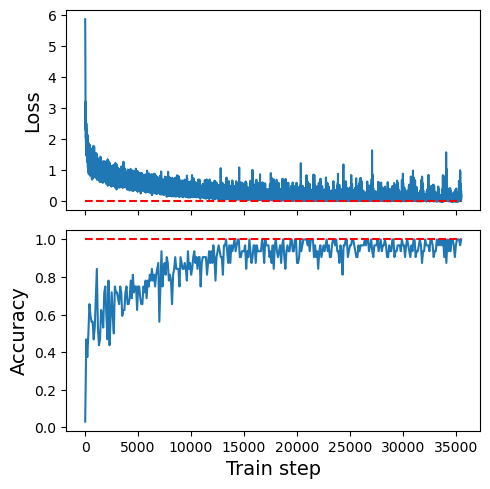

In [38]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Evaluate

In [40]:
dataset._df

,expnum,ra,dec,exptime,filter,propid,program,teff,fwhm,datetime,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff,timestamp,night
0,229250,301.199036,-50.938332,90,g,2012B-0001,survey,0.41,1.15,2013-08-31 23:55:07,139.550003,32.209999,-33.208458,1.18,1.15,0.42,1.26,0.41,1377993307,2013-08-31
1,229251,300.851105,-52.967278,90,g,2012B-0001,survey,0.60,1.18,2013-08-31 23:57:08,143.320007,32.759998,-32.380917,1.19,1.18,0.15,1.23,0.60,1377993428,2013-08-31
2,229252,300.460083,-54.996220,90,g,2012B-0001,survey,0.62,1.17,2013-08-31 23:59:08,146.949997,33.419998,-31.494499,1.20,1.17,-0.07,1.22,0.62,1377993548,2013-08-31
3,229253,300.016754,-57.024887,90,g,2012B-0001,survey,0.52,1.29,2013-09-01 00:01:11,150.449997,34.209999,-30.536041,1.21,1.29,-0.21,1.20,0.52,1377993671,2013-08-31
4,229254,302.722076,-58.040192,90,g,2012B-0001,survey,0.44,1.40,2013-09-01 00:03:13,150.589996,35.759998,-32.738377,1.23,1.40,0.04,1.20,0.44,1377993793,2013-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,230147,346.580597,-51.123997,90,i,2012B-0001,survey,0.96,1.00,2013-09-03 06:06:16,205.660004,24.170000,16.417084,1.10,1.00,-0.03,6.62,0.96,1378188376,2013-09-02
440,230148,352.174561,-53.153000,90,g,2012B-0001,survey,0.66,1.17,2013-09-03 06:08:36,196.779999,24.370001,11.475708,1.10,1.17,-0.07,1.14,0.66,1378188516,2013-09-02
441,230149,352.174530,-53.153027,90,r,2012B-0001,survey,0.69,1.11,2013-09-03 06:10:34,197.330002,24.469999,11.893500,1.10,1.11,-0.07,2.76,0.69,1378188634,2013-09-02
442,230194,9.097217,-40.979858,45,Y,2012B-0001,survey,0.35,1.40,2013-09-03 09:57:04,240.869995,42.860001,51.866333,1.36,1.40,0.07,15.51,0.35,1378202224,2013-09-02


In [41]:
unique_elements, counts = np.unique([(ra, dec) for ra, dec in zip(dataset._df['ra'].values, dataset._df['dec'].values)], axis=0, return_counts=True)

In [42]:
# given time t and current state, pick sky bin
# in sky bin, calculate which fields are in sky bin at time t
# 

In [43]:
import random

In [44]:
eval_actions = []
success_sequence = []
azel_sequence = [(az, el) for az, el in zip (dataset.states[:, 0], dataset.states[:, 1])]

with torch.no_grad():
    for i, state in enumerate(dataset.states):
        q_vals = agent.algorithm.policy_net(state).unsqueeze(0)
        action = torch.argmax(q_vals, dim=1).item()
        eval_actions.append(action)
        
        candidates_in_bin = np.array(dataset.id2azel[action])
        success_sequence.append(azel_sequence[i] in candidates_in_bin)
        dataset.actions

In [48]:
len(eval_sequence), len(mask_first_obs)

(444, 444)

In [57]:
np.count_nonzero(mask_first_obs)

3

In [60]:
first_obs_in_night_indices = []
for key, indices in dataset._groups.indices.items():
    first_obs_in_night_indices.append(indices[0])

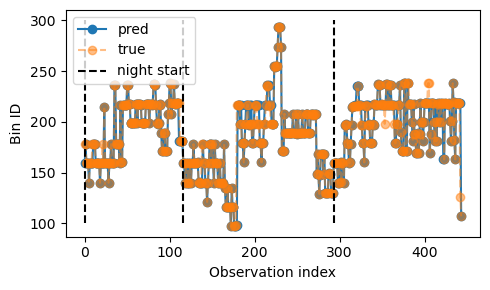

In [62]:
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions
mask_first_obs = dataset.states[:, 0] == 0. 

fig, axs = plt.subplots(1, figsize=(5,3))
axs.plot(eval_sequence, marker='o', label='pred')
axs.plot(target_sequence, marker='o', linestyle='dashed', label='true', alpha=.5)
axs.set_xlabel('Observation index')
axs.set_ylabel('Bin ID')
axs.vlines(first_obs_in_night_indices, ymin=100, ymax=300, linestyle='--', color='black', label='night start')
axs.legend()

# axs[1].plot(eval_sequence - target_sequence, marker='o')
# axs[1].legend()
# axs[1].set_xlabel('obs index')
# axs[1].set_ylabel('pred - true')

fig.tight_layout()
fig.savefig(fig_outdir + 'learned_sequence.png')

In [ ]:
# oct/nov of 2014